<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers

In [163]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [164]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [165]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [166]:
model = tf.keras.Sequential()

model.add(layers.Flatten(input_shape=(28, 28)))

model.add(layers.Dense(1000, activation='sigmoid'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1000, activation='sigmoid'))
# model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(500, activation='sigmoid'))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10))
# model.add(layers.Softmax())

In [167]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [168]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(train_images,
                    train_labels,
                    epochs=40,
                    batch_size=128,
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy:', test_acc)

Epoch 1/40
469/469 [==============================] - 28s 57ms/step - loss: 0.8046 - accuracy: 0.6971 - val_loss: 0.4913 - val_accuracy: 0.8218
Epoch 2/40
469/469 [==============================] - 27s 58ms/step - loss: 0.4825 - accuracy: 0.8246 - val_loss: 0.4327 - val_accuracy: 0.8415
Epoch 3/40
469/469 [==============================] - 27s 57ms/step - loss: 0.4352 - accuracy: 0.8424 - val_loss: 0.4152 - val_accuracy: 0.8494
Epoch 4/40
469/469 [==============================] - 28s 59ms/step - loss: 0.4067 - accuracy: 0.8525 - val_loss: 0.3973 - val_accuracy: 0.8571
Epoch 5/40
469/469 [==============================] - 29s 61ms/step - loss: 0.3849 - accuracy: 0.8601 - val_loss: 0.3944 - val_accuracy: 0.8589
Epoch 6/40
469/469 [==============================] - 27s 57ms/step - loss: 0.3686 - accuracy: 0.8654 - val_loss: 0.3775 - val_accuracy: 0.8633
Epoch 7/40
469/469 [==============================] - 26s 55ms/step - loss: 0.3590 - accuracy: 0.8689 - val_loss: 0.3620 - val_accuracy:

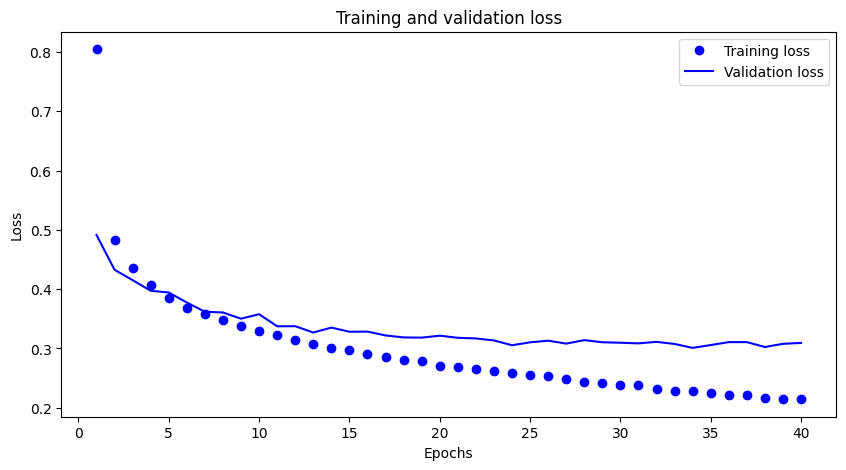

<Figure size 640x480 with 0 Axes>

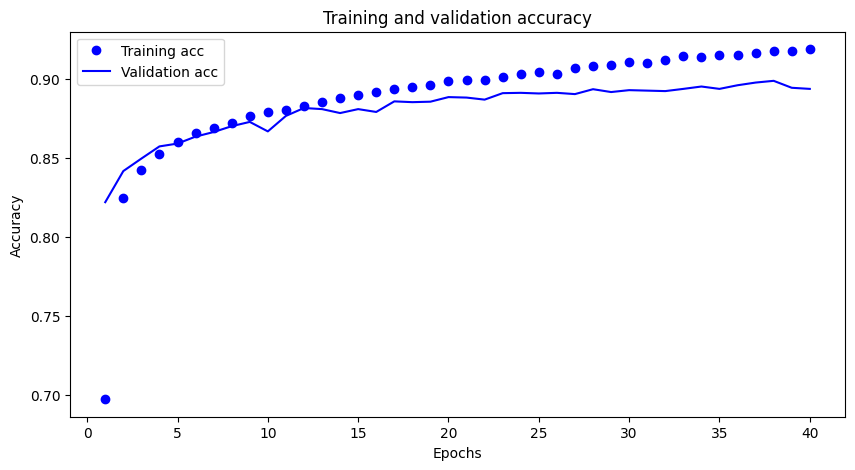

In [169]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [170]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [171]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 2s 7ms/step


In [172]:
predictions[0]

array([3.7317449e-08, 7.0426658e-08, 1.0293139e-09, 1.3289105e-08,
       5.3540870e-09, 7.5110736e-05, 2.5372017e-07, 6.4844452e-04,
       4.1092103e-09, 9.9927616e-01], dtype=float32)